In [1]:

from mpl_toolkits.mplot3d import Axes3D  
import numpy as np
import scipy as sp
from pylab import show,hist,subplot,figure 
from numpy import linalg as nla
import matplotlib.pyplot as plt
from copy import copy, deepcopy
from matplotlib import pyplot
import matplotlib.font_manager as font_manager


In [2]:

# initialise NR ligands in a (Lx,Ly) rectangle
#     cuts is a short distance cutoff 
#     Rec_state initialized to 0 (free receptors), 1 if bound

def x_Gauss_random():
    rnd=np.random.rand(2)
    rr=np.sqrt(-2.*np.log(1.-rnd[0]))
    rr=rr*np.cos(2*np.pi*rnd[1])
    return rr

# GRADIENT with a gradient P(x) ~ a + b x
#
# x= -a/b + ( (a/b)**2 + u( 2(a/b)L+L**2 ) )**0.5
#
def xy_LxLy_random(Lx,Ly,a,b):
    rnd=np.random.rand(2)
    aob=a/b
    rx=-aob+np.sqrt(aob*aob+rnd[0]*(2*aob*Lx+Lx*Lx))
    ry=rnd[1]*Ly
    return np.array([rx,ry])

# square distance between two vectors 
def distance2(r1,r2):
    dist2=(r1[0]-r2[0])**2+(r1[1]-r2[1])**2
    return dist2

def initialize_rec(Lx,Ly,a,b,NR,cut2):
    Rec_Vec=xy_LxLy_random(Lx,Ly,a,b)
    ir=0
    while(ir<NR-1):
        if(cut2>0.):
            d2=-1.
            while(d2<cut2):
                d2=2*cut2
                r_trial=xy_LxLy_random(Lx,Ly,a,b)
                for ick in range(ir+1):
                    if(ir==0):
                        r_r=Rec_Vec
                    else:
                        r_r=Rec_Vec[ick]
                    d2_act=distance2(r_trial,r_r)
                    if(d2_act<d2):
                        d2=d2_act
        else:
            r_trial=xy_LxLy_random(Lx,Ly,a,b)
        Rec_Vec=np.vstack((Rec_Vec,r_trial))
        ir=ir+1
    Rec_state=np.zeros(NR)
    return Rec_Vec, Rec_state


In [3]:

# function to initialise the Verlet list along with covered, covered_bound and covered_free ligands
#    rCM/R center of mass/radius of the particle
#    receptor in the vector list at a distance d, R-delta<d<R+delta, of the center of mass; delta<R 

def initialise_covered_Verlet(Rec_vec,Rec_state,rCM,R,delta):

    if (delta>R):
        print('delta>R in initialise_covered_Verlet')
        return

    NR=np.shape(Rec_state)[0]

    list_covered=np.array([],dtype='int_')
    list_bound_covered=np.array([],dtype='int_')
    list_free_covered=np.array([],dtype='int_')
    list_Verlet=np.array([],dtype='int_')

    ir=0
    while(ir<NR):
        r_ir=Rec_Vec[ir]
        d2=distance2(r_ir,rCM)
        if(d2<R*R):
            list_covered=np.append(list_covered,ir)
            if(Rec_state[ir]==0):
                list_free_covered=np.append(list_free_covered,ir)
            else:
                list_bound_covered=np.append(list_bound_covered,ir)
        if(d2<(R+delta)*(R+delta) and d2>(R-delta)*(R-delta)):
            list_Verlet=np.append(list_Verlet,ir)
        if(Rec_state[ir]==1 and d2>R*R):
            print('problem in initialise_cov_Verlet, a bound receptor is not covered')

        ir=ir+1
    return list_Verlet, list_covered, list_bound_covered, list_free_covered

def Vec_from_list(Rec_Vec,llst):
    if(np.shape(llst)[0]>0):
        Rec_Vec_list=Rec_Vec[llst[0]]
    else:
        return
    ii=1
    while(ii<np.shape(llst)[0]):
        r_trial=np.array([Rec_Vec[llst[ii],0],Rec_Vec[llst[ii],1]])
        Rec_Vec_list=np.vstack((Rec_Vec_list,r_trial))
        ii+=1
    return Rec_Vec_list


In [4]:

# here we update the list of covered ligands following an update of the particle center of mass 
def update_covered(Rec_Vec, Rec_state, rCMold, rCMnew, R, list_Verlet, list_covered, list_bound_covered, list_free_covered):
        nVerl=np.shape(list_Verlet)[0]
        iVerl=0
        while(iVerl<nVerl):
            i_d=list_Verlet[iVerl]
            r_id=Rec_Vec[i_d]
            d2old=distance2(r_id,rCMold)
            d2new=distance2(r_id,rCMnew)
            if(d2old<R*R and d2new>R*R):
                if(Rec_state[i_d]==1):
                    print('1-in update_covered a bound receptor left the covered region')
                    return
                list_covered=remove(i_d,list_covered)
                list_free_covered=remove(i_d,list_free_covered)
            if(d2old>R*R and d2new<R*R):
                if(Rec_state[i_d]==1):
                    print('2-in update_covered a bound receptor left the covered region')
                    return
                list_covered=add(i_d,list_covered)
                list_free_covered=add(i_d,list_free_covered)
            iVerl+=1
        return list_covered, list_free_covered

def remove(i,vec):
    nn=np.shape(vec)[0]
    iin=0
    pos_i=-1
    while(iin<nn):
        if(vec[iin]==i):
            pos_i=iin
        iin+=1
    vv1, vv2 = np.split(vec,[pos_i+1])
    vv3, vv4 = np.split(vv1,[pos_i])
    vv3=np.append(vv3,vv2)
    del vv1, vv2, vv4
    return vv3

def add(i,vec):
    vec=np.append(vec,i)
    return vec


# Track the CBs 

In [5]:


###############################################################################################
## gen_GCH: find the elements of Rec_Vec which actually constrain the vesicle (i.e. the constraining bridges 
##                   [Lowensohn, Stevens et al JCP2022]
##                   we assume  number_bridges > 2 
## update_GCH: update the GCH following the formation of a bridge 
###############################################################################################

def update_GCH(Rec_Vec,list_GCH,irc,R):

    wp=Rec_Vec[irc]
    w_test=wp.copy()
    already_inserted = 0
    new_list_GCH=np.array([],dtype='int_')        
    new=0 # =1 if list_GCH will be updated by the current move
    #
    if(np.shape(list_GCH)[0]<2):
        new_list_GCH=list_GCH.copy()
        new_list_GCH=np.append(new_list_GCH,irc)
        new=1
        return new, new_list_GCH
    #
    for i_Hull in range(np.shape(list_GCH)[0]):
        wp1=Rec_Vec[list_GCH[i_Hull]]
        wp2=Rec_Vec[list_GCH[np.mod(i_Hull+1,np.shape(list_GCH)[0])]]
        w2=wp2.copy()
        w1=wp1.copy()            
        c=center(w1, w2, R)
        dwc2=distance2(c,w_test)
        if(dwc2>R*R):
            f=1 # w_test not contained
            new=1
        else:
            f=0 # w_test contained
        if(f==1): # not contained
            if(already_inserted==0):
                new_list_GCH=np.append(new_list_GCH,irc)
                already_inserted=1
        if(f==0): # contained
            if(i_Hull == 0):
                new_list_GCH=np.append(new_list_GCH,list_GCH[i_Hull])
            else: 
                if(new_list_GCH[np.shape(new_list_GCH)[0]-1]!=list_GCH[i_Hull]):
                    new_list_GCH=np.append(new_list_GCH,list_GCH[i_Hull])
            if(new_list_GCH[0] != list_GCH[np.mod(i_Hull+1,np.shape(list_GCH)[0])]):
                new_list_GCH=np.append(new_list_GCH,list_GCH[np.mod(i_Hull+1,np.shape(list_GCH)[0])])

    if(np.shape(new_list_GCH)[0]==1):
        if(new_list_GCH[0] != irc):
            print('some problems when new GCH contains a single point')
        dist=0
        rc2=-1
        for iir in range(np.shape(list_GCH)[0]):
            wp_iir=Rec_Vec[list_GCH[iir]]
            w_iir=wp_iir.copy()
            dist_test=distance2(w_test,w_iir)
            if(dist_test > dist):
                dist=dist_test
                rc2=list_GCH[iir]
            iir=iir+1
        new_list_GCH=np.append(new_list_GCH,rc2)
        if(rc2==-1):
            print("problem in update_GCH")
    return new, new_list_GCH

def gen_GCH(Rec_Vec,list_bound_covered,R):

    if(np.shape(list_bound_covered)[0]<2):
        print('in gen_GCH(): attempting to calculate a GCH with less than 2 bridges')
        list_GCH=list_bound_covered.copy()
        return list_GCH

    list_GCH=np.array([],dtype='int_')
    list_GCH=np.append(list_GCH,list_bound_covered[0])
    list_GCH=np.append(list_GCH,list_bound_covered[1])

    irc=2

    while(irc<np.shape(list_bound_covered)[0]):  

        new_list_GCH = np.array([],dtype='int_')
        new, new_list_GCH = update_GCH(Rec_Vec,list_GCH,list_bound_covered[irc],R)
        list_GCH=np.array([],dtype='int_')
        list_GCH=new_list_GCH.copy()

        irc=irc+1

    return list_GCH

def center(v1, v2, R):
    m=(v1+v2)/2
    v12=v2-v1
    u=np.array([-v12[1],v12[0]])
    u=u/np.sqrt(u[0]*u[0]+u[1]*u[1])
    if(v12[0]*u[1]-v12[1]*u[0]<0):
        u=-u
    dist=np.sqrt(R*R-0.25*v12[0]*v12[0]-0.25*v12[1]*v12[1])
    c=np.array([m[0]+dist*u[0],m[1]+dist*u[1]])
    return c


In [6]:
# Functions to sample uniformly the vesicle configuration space

In [7]:

# provide the intersection point between two lines
#   r1 : v[] + t a[]
#   r2 : w[] + p b[]

def intersection_r1_r2(v,a,w,b):
    den=b[0]*a[1]-b[1]*a[0]
    if(np.abs(den)<np.power(10.,-10)):
        print('overlapping CBs')
        return (v+w)/2
    t=b[0]*(w[1]-v[1])-b[1]*(w[0]-v[0])
    t=t/den
    return v+a*t

def Limit_CM_adv(Rec_Vec,list_GCH,rCM,R):
    ncb=np.shape(list_GCH)[0]
    if(ncb==2):
        r1p=Rec_Vec[list_GCH[0]]
        r2p=Rec_Vec[list_GCH[1]]
        r1=r1p.copy()
        r2=r2p.copy()
        z1=center(r1, r2, R)
        z2=center(r2, r1, R)
        zm=(z1+z2)/2
        dd=np.sqrt(np.power(zm[0]-r1[0],2)+np.power(zm[1]-r1[1],2))
        dd=R-dd
        if(dd<0):
            print("problems in Limit_CM_adv, ncb==2")
        u=r1-zm
        u=u/np.sqrt(np.power(r1[0]-zm[0],2)+np.power(r1[1]-zm[1],2))
        u=u*dd
        k1=z1+u
        k2=z1-u
        k3=z2+u
        k4=z2-u
        wx=np.array([k1[0],k2[0],k3[0],k4[0]])
        wy=np.array([k1[1],k2[1],k3[1],k4[1]])
    elif(ncb>2):
        wx=np.array([])
        wy=np.array([])
        for i in range(ncb):
            r1p=Rec_Vec[list_GCH[i]]
            r2p=Rec_Vec[list_GCH[np.mod(i+1,ncb)]]
            r3p=Rec_Vec[list_GCH[np.mod(i+2,ncb)]]
            r1=r1p.copy()
            r2=r2p.copy()
            r3=r3p.copy()
            v=center(r1, r2, R)
            w=center(r2, r3, R)
            a=r1-r2
            b=r2-r3
            vint=intersection_r1_r2(v,a,w,b)
            wx=np.append(wx,vint[0])
            wy=np.append(wy,vint[1])
    r_min=rCM.copy()
    r_max=rCM.copy()
#   print(wx,wy)
    for irc in range(np.shape(wx)[0]):
        if(r_min[0]>wx[irc]):
            r_min[0]=wx[irc]
        if(r_min[1]>wy[irc]):
            r_min[1]=wy[irc]
        if(r_max[0]<wx[irc]):
            r_max[0]=wx[irc]
        if(r_max[1]<wy[irc]):
            r_max[1]=wy[irc]
    return r_min, r_max 

#return a vector inside the rectangle identified by r_min, r_max
def UnSamp(r_min, r_max):
    rnd=np.random.rand(2)
    r=np.array([0.,0.])
    r[0]=r_min[0]+(r_max[0]-r_min[0])*rnd[0]
    r[1]=r_min[1]+(r_max[1]-r_min[1])*rnd[1]
    return r 

# we assume more than two bridges # not used here
def Check_No_Breakage(Rec_Vec,list_GCH,r_trial,R):
    nbk=1.
    for irc in range(np.shape(list_GCH)[0]):
        if(distance2(Rec_Vec[list_GCH[irc]],r_trial)>R*R):
            nbk=0.
            return nbk
    return nbk


# identical to the previous function but, in this case, we only use bridges in the GCH 
#    to sample available GUV configurations
# this function has not been debugged
def Sample_Conf_GCH(Rec_Vec,list_GCH,rCM,R):
    # Rec_Vec_GCH are the position of the bridges entering the GCH 
    r_min, r_max=Limit_CM_adv(Rec_Vec,list_GCH,rCM,R) 
#    r_min, r_max=Limit_CM(Rec_Vec_GCH,rCM,R)
#    print('r_min, rmax')
#    print(r_min,r_max)
    no_bk=0.
    while(no_bk<0.5):
        r_trial=UnSamp(r_min, r_max)
        no_bk=Check_No_Breakage(Rec_Vec, list_GCH,r_trial,R)
    return r_trial

# Return the center of a circle of radius R supporting v1 and v2.
# ....... v1 finds v2 anticlockwise 
def center(v1, v2, R):
    m=(v1+v2)/2
    v12=v2-v1
    u=np.array([-v12[1],v12[0]])
    u=u/np.sqrt(u[0]*u[0]+u[1]*u[1])
    if(v12[0]*u[1]-v12[1]*u[0]<0):
        u=-u
    dist=np.sqrt(R*R-0.25*v12[0]*v12[0]-0.25*v12[1]*v12[1])
    c=np.array([m[0]+dist*u[0],m[1]+dist*u[1]])
    return c





# Fire reactions

In [8]:

# make a reaction 
def bind(i_d, list_bound_covered, list_free_covered,Rec_state,Rec_Vec,list_CGH):
    if(Rec_state[i_d]==1):
        print('error in bind(); i_d=', i_d)
        return
    Rec_state[i_d]=1
    list_bound_covered=add(i_d,list_bound_covered)
    list_free_covered=remove(i_d,list_free_covered)
    #
    new,new_list_GCH=update_GCH(Rec_Vec,list_GCH,i_d,R)
    #
    return list_bound_covered,list_free_covered,Rec_state,new_list_GCH,new

def unbind(i_d, list_bound_covered, list_free_covered,Rec_state,Rec_Vec,list_GCH):
    if(Rec_state[i_d]==0):
        print('error in unbind(); i_d=', i_d)
        return
    Rec_state[i_d]=0
    list_free_covered=add(i_d,list_free_covered)
    list_bound_covered=remove(i_d,list_bound_covered)
    #
    in_the_GCH=0        
    for iGCH in range(np.shape(list_GCH)[0]): 
        if(list_GCH[iGCH]==i_d):
            in_the_GCH=1
    if(in_the_GCH==1):
        new=1
        new_list_GCH=gen_GCH(Rec_Vec,list_bound_covered,R)
    else:
        new=0
        new_list_GCH=list_GCH
    #
    return list_bound_covered,list_free_covered,Rec_state,new_list_GCH,new

# NL: total number of receptors
def reaction(t_r,Dt,kon,koff,NL,list_bound_covered,list_free_covered,Rec_state,Rec_Vec,list_GCH):
    nb=np.shape(list_bound_covered)[0]
    aon=(NL-nb)*np.shape(list_free_covered)[0]*kon
    aoff=nb*koff
    rnd=np.random.rand(2)
    d_t=-np.log(1-rnd[0])/(aon+aoff)
    t_r+=d_t
    new=0
    if(t_r<Dt):
        if(rnd[1]<aon/(aon+aoff)):
            i_vec=np.random.randint(0,high=np.shape(list_free_covered)[0],size=1,dtype=int)[0]
            i_d=list_free_covered[i_vec]
            list_bound_covered,list_free_covered,Rec_state,list_GCH,new=bind(i_d,list_bound_covered,list_free_covered,Rec_state,Rec_Vec,list_GCH)
            #print('++++binding',i_d)
        else:
            i_vec=np.random.randint(0,high=np.shape(list_bound_covered)[0],size=1,dtype=int)[0]
            i_d=list_bound_covered[i_vec]
            list_bound_covered,list_free_covered,Rec_state,list_GCH,new=unbind(i_d,list_bound_covered,list_free_covered,Rec_state,Rec_Vec,list_GCH)
            #print('----unbinding',i_d)
    return t_r,list_bound_covered,list_free_covered,Rec_state,list_GCH,new


In [9]:

# return 1 if some of the bound ligands do not overlap with the new circle position 
#   feed this function with list_CB (instead of list_bound_covered) to obtain an O(1) routine 
def check_breakage(rCM,R,list_,Rec_Vec):
    bkg=0
    ii=0
    nb=np.shape(list_)[0]
    while(ii<nb):
        vr=Rec_Vec[list_[ii]]
        d2=distance2(vr,rCM)
        if(d2>R*R):
            bkg=1
            return bkg
        ii+=1
    return bkg


In [10]:

def Plot_bridges_CB(rCM,R,list_bound_covered,list_GCH,Rec_Vec):

    x_r=np.array([])
    y_r=np.array([])
    for ib in range(np.shape(list_bound_covered)[0]):
        x_r=np.append(x_r,Rec_Vec[list_bound_covered[ib],0])
        y_r=np.append(y_r,Rec_Vec[list_bound_covered[ib],1])

    x_GCH=np.array([])
    y_GCH=np.array([])
    for iGCH in range(np.shape(list_GCH)[0]):
        x_GCH=np.append(x_GCH,Rec_Vec[list_GCH[iGCH],0])
        y_GCH=np.append(y_GCH,Rec_Vec[list_GCH[iGCH],1])

    x_line=np.array([])
    y_line=np.array([])
    dthe=np.pi/1000.

    if(np.shape(list_GCH)[0]>1):
        for iGCH in range(np.shape(list_GCH)[0]):
            wp1=Rec_Vec[list_GCH[iGCH]]
            wp2=Rec_Vec[list_GCH[np.mod(iGCH+1,np.shape(list_GCH)[0])]]
            w1=wp1.copy()
            w2=wp2.copy()
            c=center(w1, w2, R)
            igh=0
            the1=np.arccos((w1[0]-c[0])/R)
            if(w1[1]-c[1]<0):
                the1=2.*np.pi-the1
            the2=np.arccos((w2[0]-c[0])/R)
            if(w2[1]-c[1]<0):
                the2=2.*np.pi-the2
            if(the2<the1):
                the2=the2+2*np.pi
            dthe=2*np.pi/1000.
            the=the1
            while(the<the2):
                the=the+dthe
                xt=c[0]+R*np.cos(the)
                yt=c[1]+R*np.sin(the)
                x_line=np.append(x_line,xt)
                y_line=np.append(y_line,yt)

    x_line_center=np.array([])
    y_line_center=np.array([])
    igh=0
    the=0
    while(igh<1000):
        the=np.pi*2*igh/1000
        xt=R*np.cos(the)+rCM[0]
        yt=R*np.sin(the)+rCM[1]
#        if(xt*xt+yt*yt<R*R):
        x_line_center=np.append(x_line_center,xt)
        y_line_center=np.append(y_line_center,yt)
        igh=igh+1

    f = plt.figure()
    f.set_figwidth(5)
    f.set_figheight(5)

    plt.rc('axes', labelsize=20)
    plt.rc('xtick', labelsize=15)
    plt.rc('ytick', labelsize=15)
    plt.xlabel(r'$x$')
    plt.ylabel(r'$y$')

    #plt.text(0.83, 0.9, '(b)', fontsize = 22)
    #plt.text(0.55, -1.025, r'$A_\mathrm{out}$', fontsize = 35)
    #plt.text(0.25, 0.25, r'$A_\mathrm{in}$', fontsize = 35)

    #v1=np.array([0.55,0.35])
    #v2=np.array([-0.95,-0.85])

    plt.scatter(x_r,y_r,s=10,c="blue") 
    plt.scatter(x_line, y_line, s=1, c="gray")
    plt.scatter(x_line_center, y_line_center, s=1,c="black")
    plt.scatter(x_GCH,y_GCH,c="red")
    #plt.plot(v1,v2,c="black")
    plt.show()


In [11]:

# average distance between pairs of unbound ligands (receptors) equal to dav
# 

#dav=7.5
#rho=1/dav/dav

rho=0.021
rhoR=0.008

R=100.
Lx=2000.
Ly=2000.
#
#
NL=int(3*np.pi*R*R*rhoR)
# 
NR=int(Lx*Ly*rho)
#
print(NR,NL)
#


35555 558


# Simulations

# set-up receptors 

In [12]:
#
# GRADIENTS: particle placed on the left edge of the simulation plane 
rCM=np.array([Lx/2,Ly/2])
#
cut2=-1.
delta=R/20.
# deterministic runs
# np.random.seed(667)
#
lam=5
#b=rho/Lx
#a=rho-b*Lx/2
b=rho/lam/Lx
a=rho-rho/2/lam
#
Rec_Vec, Rec_state = initialize_rec(Lx,Ly,a,b,NR,cut2)
#
print('Rec_Vec initialised')
list_Verlet, list_covered, list_bound_covered, list_free_covered = initialise_covered_Verlet(Rec_Vec,Rec_state,rCM,R,delta)
list_GCH=gen_GCH(Rec_Vec,list_bound_covered,R)
print('list_GCH =',list_GCH)

Rec_Vec initialised
in gen_GCH(): attempting to calculate a GCH with less than 2 bridges
list_GCH = []


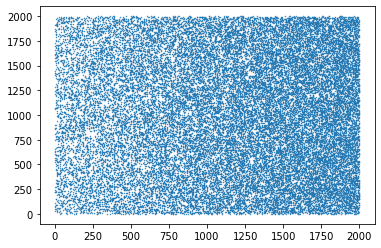

In [13]:
plt.scatter(Rec_Vec[:,0],Rec_Vec[:,1],s=0.2)
#plt.xlim([900,1100])
#plt.ylim([900,1100])
plt.show()

# setting up k_on and k_off 

In [14]:
#
# pre-runs to test the averaged number of bridges 
#
#Keq=0.000075 # kon/koff=0.000075 => nbe=22.5
#nbe=22.5
#
#Keq=0.0002 # kon/koff=0.0002 => nbe=53
#nbe=53
#
Keq=0.0005 # kon/koff=0.0005 => nbe=111
nbe=111
#
#Keq=0.001 # kon/koff=0.001 => nbe=170
#nbe=170
#
#Keq=0.005 # kon/koff=0.005 => nbe=327
#nbe=327
#
#Keq=0.02 # kon/koff=0.02 => nbe=434
#nbe=434
#
kon=100000./np.pi/R/R/10.
koff=kon/Keq
#
print('kon =',kon)
print('koff =',koff)
#

kon = 0.3183098861837907
koff = 636.6197723675814


In [ ]:
#l=5
kon=166112/np.pi/R/R/10./3
koff=1.098361278788853
#l=6
#kon=166112/np.pi/R/R/10./3
#koff=0.17438170490312313
#l=7
#kon=166112/np.pi/R/R/10./3
#koff=0.008405893941853482

In [1]:
import numpy as np
print(166112/np.pi/R/R/10./3)


NameError: name 'R' is not defined

# thermalization  

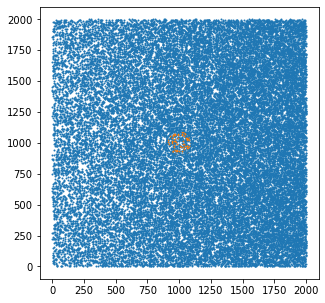

In [15]:

# thermalisation #############################################################
t=0
t_term=3.
nb_Vec=np.array([0])
nb_av_Vec=np.array([])
t_Vec=np.array([0])
while(t<t_term):
    t,list_bound_covered,list_free_covered,Rec_state,list_GCH,new=reaction(t,t_term,kon,koff,NL,list_bound_covered,list_free_covered,Rec_state,Rec_Vec,list_GCH)
#    print('t=',t)
#    print('new=',new)
#    print('list_GCH=',list_GCH)
#    print('----')
#    Plot_bridges_CB(rCM,R,list_bound_covered,list_GCH,Rec_Vec)
    if(t>t_term/2):
        nb_av_Vec=np.append(nb_av_Vec,np.shape(list_bound_covered)[0])
    nb_Vec=np.append(nb_Vec,np.shape(list_bound_covered)[0])
    t_Vec=np.append(t_Vec,t) 

# plotting figure 
# plt.plot(t_Vec,nb_Vec)
# plt.show()

Rec_Vec_list=Vec_from_list(Rec_Vec,list_bound_covered)
x_r_cov=Rec_Vec_list[:,0]
y_r_cov=Rec_Vec_list[:,1]

x_r=Rec_Vec[:,0]
y_r=Rec_Vec[:,1]

phi=np.arange(0,2*np.pi,0.2)

xc2=(R)*np.cos(phi)+rCM[0]
yc2=(R)*np.sin(phi)+rCM[1]

f=plt.figure()
f.set_figwidth(5)
f.set_figheight(5)
plt.plot(xc2,yc2) 
plt.scatter(x_r,y_r,s=1) 
plt.scatter(x_r_cov,y_r_cov,s=0.5) 
plt.show()

# Debug 

## check the consistency between list_bound_covered and Rec_state

## print(rCM)
## print(rCM_Verlet)
## print(list_free_covered)
#print(list_bound_covered)
## print(list_covered)
#ii=0
#while(ii<np.shape(Rec_state)[0]):
#    if(Rec_state[ii]==1):
#        print(ii)
#        print(Rec_Vec[ii])
#        print('dist=',np.sqrt(distance2(Rec_Vec[ii],rCM)))
#        print('----------')
#    ii+=1
  


# Runs

In [16]:

%%time

# simulations # # # 
Dt=0.01

#NBrown=100
#DtB=Dt/NBrown
t=0
t_term=100.0
iprint=int(t_term/Dt)

# variable used to reinitialise the lists when drCM>=delta #
list_Verlet, list_covered, list_bound_covered, list_free_covered = initialise_covered_Verlet(Rec_Vec,Rec_state,rCM,R,delta)
rCM_Verlet=np.array([rCM[0],rCM[1]])

nb_Vec=np.array([],dtype=int)
nb_Vec=np.append(nb_Vec,np.shape(list_bound_covered)[0])

xCM_Vec=np.array([rCM[0]])
yCM_Vec=np.array([rCM[1]])
t_Vec=np.array([0])

#xCM_Vec_det=np.array([])
#yCM_Vec_det=np.array([])

nCB_Vec=np.array([np.shape(list_bound_covered)[0]])

t_CB_Vec=np.array([])
t_CB_old=0

# figures
#f=plt.figure()
#f.set_figwidth(5)
#f.set_figheight(5)

#plt.plot(x_Omega,y_Omega)

print('simulation starts')
i=0
ii=0
while(t<t_term):

    # reaction 
    t_reac=0
    while(t_reac<Dt):
        t_reac,list_bound_covered,list_free_covered,Rec_state,list_GCH,new=reaction(t_reac,Dt,kon,koff,NL,list_bound_covered,list_free_covered,Rec_state,Rec_Vec,list_GCH)
        if(new==1):
            #print('new CB')
            t_CB_Vec=np.append(t_CB_Vec,t+t_reac-t_CB_old)
            t_CB_old=t+t_reac
            #x_Omega,y_Omega=trace_deltaOmega(Rec_Vec,list_GCH,R)
            #plt.plot(x_Omega,y_Omega)

    rCMnew=Sample_Conf_GCH(Rec_Vec,list_GCH,rCM,R)
    # update of the Verlet list
    d2CM=distance2(rCMnew,rCM_Verlet)

    if(d2CM>(0.99*delta)**2):
##                print('new Verlet')
        rCM_Verlet=np.array([rCMnew[0],rCMnew[1]])
        list_Verlet, list_covered, list_bound_covered, list_free_covered = initialise_covered_Verlet(Rec_Vec,Rec_state,rCMnew,R,delta)
    else:
        list_covered, list_free_covered=update_covered(Rec_Vec,Rec_state,rCM,rCMnew,R,list_Verlet,list_covered,list_bound_covered,list_free_covered)

    rCM=np.array([rCMnew[0],rCMnew[1]])

#            #if(NBrown*t/Dt<np.power(10,6)):
#            #    xCM_Vec_det=np.append(xCM_Vec_det,rCMnew[0])
#            #    yCM_Vec_det=np.append(yCM_Vec_det,rCMnew[1])

# Brownian diffusion
#
#    iBrown=0
#    while(iBrown<NBrown):
#        Dx=x_Gauss_random()*np.sqrt(2.*D0*DtB)
#        Dy=x_Gauss_random()*np.sqrt(2.*D0*DtB)
#        rCMnew=np.array([rCM[0]+Dx,rCM[1]+Dy])
#        bkg=check_breakage(rCMnew,R,list_GCH,Rec_Vec)
#        iBrown+=1
#        if(bkg==0):
#            d2CM=distance2(rCMnew,rCM_Verlet)
#            if(d2CM>(0.99*delta)**2):
##                print('new Verlet')
#                rCM_Verlet=np.array([rCMnew[0],rCMnew[1]])
#                list_Verlet, list_covered, list_bound_covered, list_free_covered = initialise_covered_Verlet(Rec_Vec,Rec_state,rCMnew,R,delta)
#            else:
#                list_covered, list_free_covered=update_covered(Rec_Vec,Rec_state,rCM,rCMnew,R,list_Verlet,list_covered,list_bound_covered,list_free_covered)
#            rCM=np.array([rCMnew[0],rCMnew[1]])
#            #if(NBrown*t/Dt<np.power(10,6)):
#            #    xCM_Vec_det=np.append(xCM_Vec_det,rCMnew[0])
#            #    yCM_Vec_det=np.append(yCM_Vec_det,rCMnew[1])

    # clock update
    t+=Dt
    ii+=1

    if(np.mod(ii,10)==0):
        xCM_Vec=np.append(xCM_Vec,rCMnew[0])
        yCM_Vec=np.append(yCM_Vec,rCMnew[1])
        t_Vec=np.append(t_Vec,t)
        nb_Vec=np.append(nb_Vec,np.shape(list_bound_covered)[0])

    if((rCM[0]<1.1*R)or(rCM[0]>Lx-1.1*R)or(rCM[1]<1.1*R)or(rCM[1]>Ly-1.1*R)):
        t=t_term+Dt
#    print('clock=',t)
    if(t>i*t_term/10.):
        i=i+1
        print('t =',t)
# ----------

#Rec_Vec_list=Vec_from_list(Rec_Vec,list_bound_covered)
#x_r_b=Rec_Vec_list[:,0]
#y_r_b=Rec_Vec_list[:,1]

#x_r=Rec_Vec[:,0]
#y_r=Rec_Vec[:,1]

#phi=np.arange(0,2*np.pi,0.2)

#xc2=(R)*np.cos(phi)+rCM[0]
#yc2=(R)*np.sin(phi)+rCM[1]

#dataZ=t_Vec*100/t_term-50
#plt.plot(xc2,yc2) 
#plt.scatter(xCM_Vec,yCM_Vec,c=dataZ,cmap='winter', edgecolors='none',s=10)
#plt.scatter(x_r,y_r,s=1) 
#plt.scatter(x_r_b,y_r_b,s=0.5) 
#plt.show()

#plt.plot(t_Vec, xCM_Vec)
#plt.show()

#plt.plot(t_Vec, yCM_Vec)
#plt.show()

np.save('t_Vec',t_Vec)
np.save('xCM_Vec',xCM_Vec)
np.save('yCM_Vec',yCM_Vec)
np.save('nb_Vec',nb_Vec)

#xx=np.load('xCM_Vec.npy')
#yy=np.load('yCM_Vec.npy')

#plt.plot(xx,yy)
#plt.show()


simulation starts
t = 0.0001
t = 1.0000999999999063
t = 2.0000999999997964
t = 3.0000000000019065
t = 4.000000000004016
t = 5.000000000001686
t = 6.000099999999355
t = 7.000099999997024
t = 8.000099999994694
t = 9.000099999992363
t = 10.000099999990033
CPU times: user 40min 18s, sys: 1.51 s, total: 40min 19s
Wall time: 40min 17s


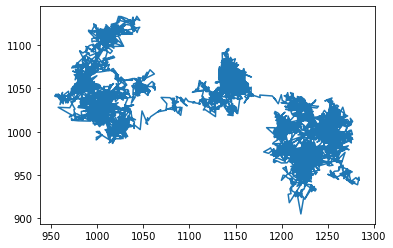

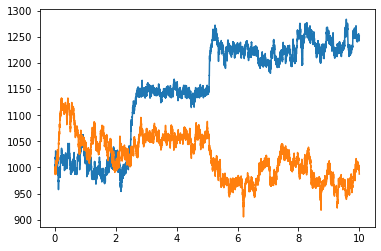

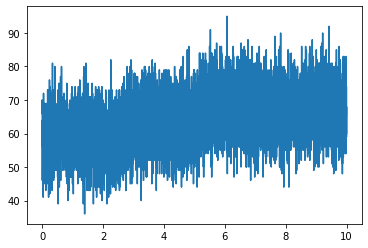

In [17]:
plt.plot(xCM_Vec,yCM_Vec)
plt.show()
plt.plot(t_Vec,xCM_Vec)
plt.plot(t_Vec,yCM_Vec)
plt.show()
plt.plot(t_Vec,nb_Vec)
plt.show()

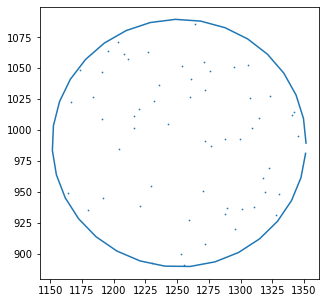

In [18]:

Rec_Vec_list=Vec_from_list(Rec_Vec,list_bound_covered)
x_r_cov=Rec_Vec_list[:,0]
y_r_cov=Rec_Vec_list[:,1]

x_r=Rec_Vec[:,0]
y_r=Rec_Vec[:,1]

phi=np.arange(0,2*np.pi,0.2)

xc2=(R)*np.cos(phi)+rCM[0]
yc2=(R)*np.sin(phi)+rCM[1]

f=plt.figure()
f.set_figwidth(5)
f.set_figheight(5)
plt.plot(xc2,yc2) 
#plt.scatter(x_r,y_r,s=1) 
plt.scatter(x_r_cov,y_r_cov,s=0.5) 
plt.show()
